<a href="https://colab.research.google.com/github/octaviasst/LEARN-CNN/blob/main/percobaan01_HRV_Analize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neurokit2

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


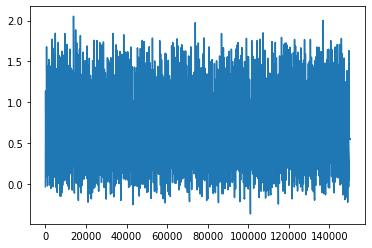

In [2]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
from matplotlib.patches import Ellipse

ppg_simulated=nk.ppg_simulate(duration=300, sampling_rate=500, heart_rate=60)
plt.plot(ppg_simulated)
plt.show()

time domain analyze

In [3]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

In [4]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

In [5]:
def plot_poincare(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)
    
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    
    return sd1, sd2

In [6]:
ppg_and_ecg=nk.data(dataset="bio_resting_5min_100hz")

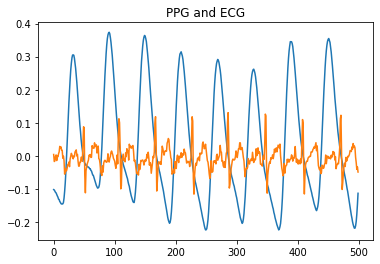

In [7]:
plt.plot(ppg_and_ecg['PPG'][0:500])
plt.plot(ppg_and_ecg['ECG'][0:500])
plt.title("PPG and ECG", color = "black")
plt.tick_params(axis="both", colors = "black")

In [8]:
diff_sig_2=np.diff(ppg_and_ecg['PPG'])

In [9]:
# HR will probably not go below 30 bpm : distance=500*(30/60))
# prominence found experimentally
peaks_2, _ = find_peaks(diff_sig_2, distance=100*(30/60), prominence=0.01)

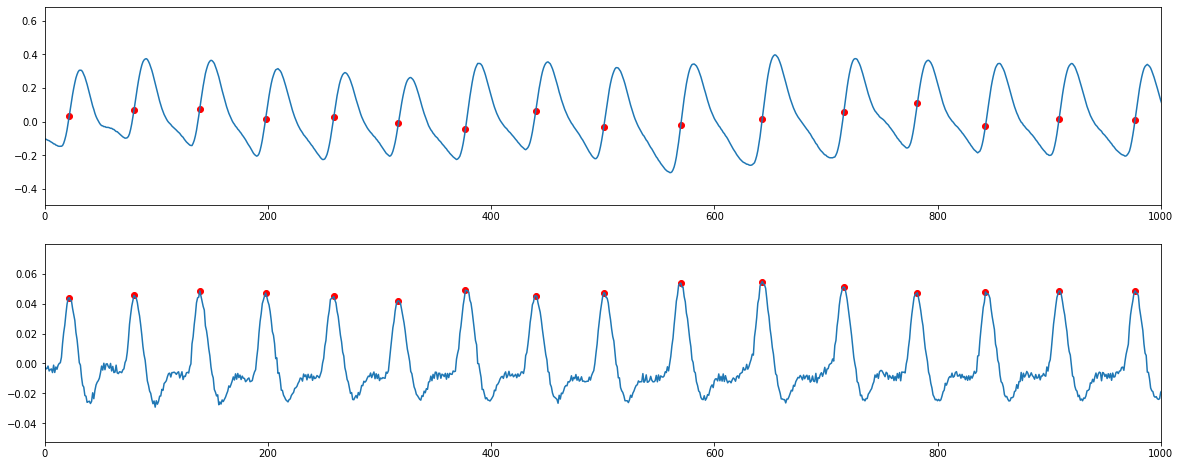

In [10]:
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.plot(ppg_and_ecg['PPG'])
plt.scatter(peaks_2, ppg_and_ecg['PPG'][peaks_2], color="red")
plt.gca().set_xlim(0, 1000)
plt.subplot(2,1,2)
plt.plot(diff_sig_2)
plt.scatter(peaks_2, diff_sig_2[peaks_2], color="red")
plt.gca().set_xlim(0, 1000)
plt.show()

In [11]:
rr_2 = np.diff(peaks_2)
corr_rr_2 = rr_2*10

In [12]:
timedomain(corr_rr_2)

{'Max HR (beats/min)': 109.0909090909091,
 "Mean HR (Kubios' style) (beats/min)": 86.3785155989044,
 'Mean HR (beats/min)': 86.84239408606393,
 'Mean RR (ms)': 694.6171693735499,
 'Min HR (beats/min)': 68.18181818181819,
 'NNxx': 67,
 'RMSSD (ms)': 41.07848415490908,
 'STD HR (beats/min)': 6.354812992315708,
 'STD RR/SDNN (ms)': 51.03821944801512,
 'pNNxx (%)': 15.54524361948956}

NameError: ignored

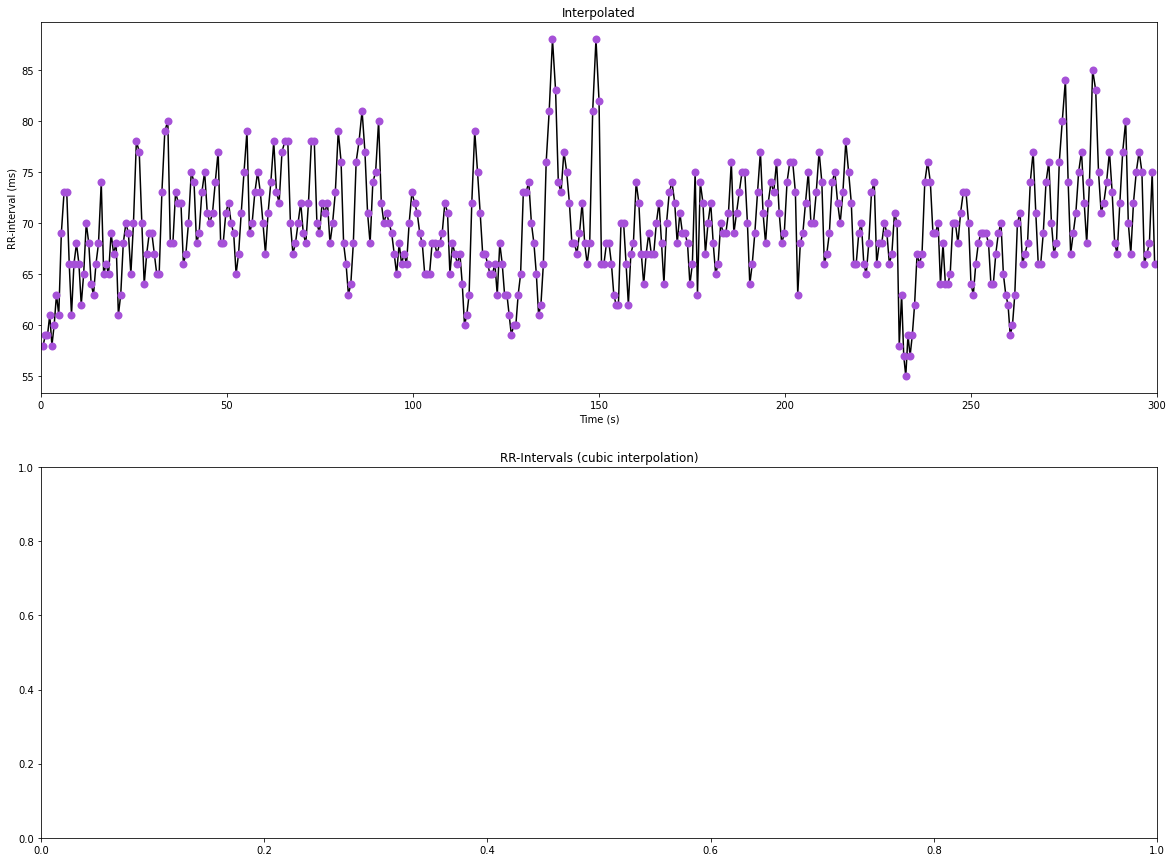

In [13]:
x_2 = np.cumsum(rr_2)/ 100.0
f_2 = interp1d(x_2, rr_2, kind='cubic',fill_value="extrapolate")

# sample rate for interpolation
fs = 4.0
steps = 1 / fs

# now we can sample from interpolation function
xx_2 = np.arange(1, np.max(x_2), steps)

rr_interpolated = f_2(xx_2)

plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("RR intervals")
plt.plot(x_2, rr_2, color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.title("Interpolated")
plt.gca().set_xlim(0, 300)

plt.subplot(212)
plt.title("RR-Intervals (cubic interpolation)")
plt.plot(xx_2, rr_interpolated_2, color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=8)
plt.gca().set_xlim(0, 300)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.show()

In [14]:
print("Frequency domain metrics:")
results_2, fxx_2, pxx_2 = frequency_domain(rr_interpolated)

for k, v in results_2.items():
    print("- %s: %.2f" % (k, v))

Frequency domain metrics:
- Power VLF (ms2): 3.64
- Power LF (ms2): 7.07
- Power HF (ms2): 7.81
- Power Total (ms2): 18.53
- LF/HF: 0.91
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.09
- Peak HF (Hz): 0.28
- Fraction LF (nu): 47.51
- Fraction HF (nu): 52.49


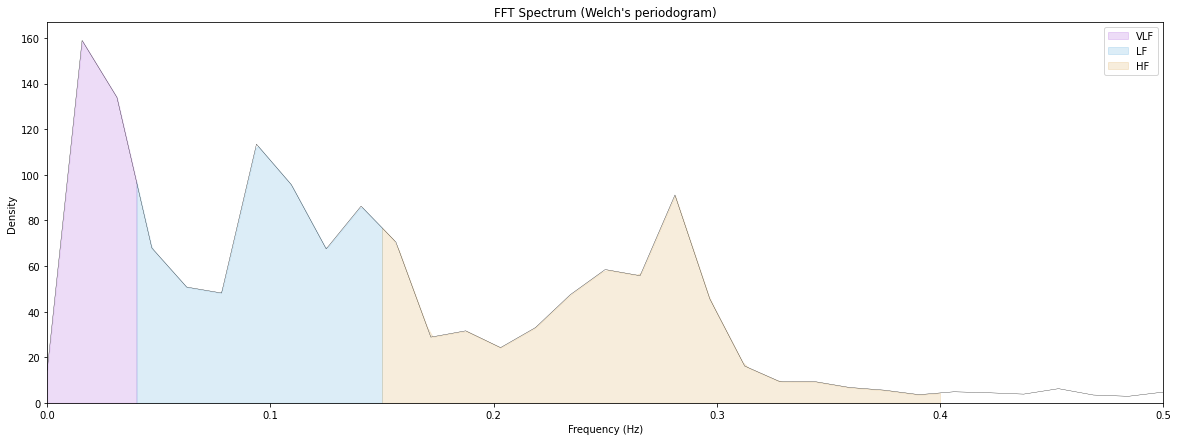

In [15]:
plt.figure(figsize=(20, 7))
plt.plot(fxx_2, pxx_2, color="k", linewidth=0.3)
plt.title("FFT Spectrum (Welch's periodogram)")

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx_2, pxx_2)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()

SD1: 2.905 ms
SD2: 6.592 ms


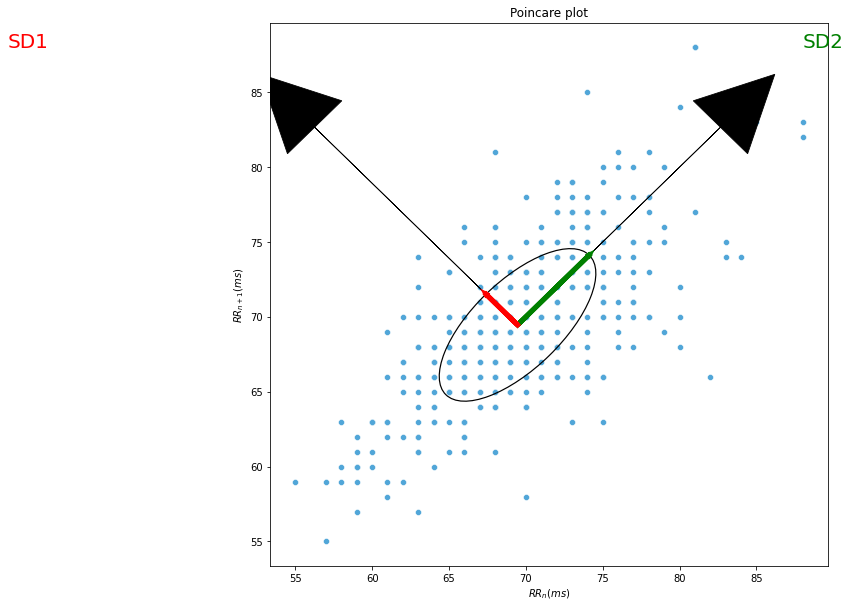

In [16]:
import seaborn as sns
from matplotlib.patches import Ellipse
sd1_2, sd2_2 = plot_poincare(rr_2)
print("SD1: %.3f ms" % sd1_2)
print("SD2: %.3f ms" % sd2_2)

In [28]:
ecg_signals, info  = nk.ecg_process(ppg_and_ecg["ECG"], sampling_rate=100)

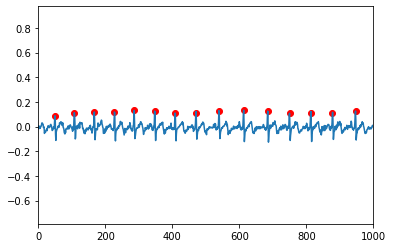

In [29]:
plt.plot(ppg_and_ecg["ECG"])
plt.scatter(info['ECG_R_Peaks'], ppg_and_ecg["ECG"][info['ECG_R_Peaks']], color="red")
plt.gca().set_xlim(0, 1000)
plt.show()

In [30]:
rr_ecg = np.diff(info['ECG_R_Peaks'])
corr_rr_ecg = rr_ecg*10

In [17]:
!pip install hrv-analysis

In [18]:
!pip install pyhrv

     |████████████████████████████████| 3.2 MB 5.0 MB/s 
     |████████████████████████████████| 228 kB 55.6 MB/s 
     |████████████████████████████████| 1.5 MB 46.0 MB/s 
  Created wheel for biosppy: filename=biosppy-0.8.0-py2.py3-none-any.whl size=100176 sha256=bf089d056f8f0978a2f96077bbf1ac4755207e891cfdd39891e9fb6913943935
  Stored in directory: /root/.cache/pip/wheels/32/17/9d/77adbf0db713546eaa1c7a1480b2dce91fa724a133115dc20c
  Created wheel for spectrum: filename=spectrum-0.8.0-cp37-cp37m-linux_x86_64.whl size=234834 sha256=c12024448615e70f96f94c9b611fcc1700ca2c5df9777ff39f6bf8094fef999e
  Stored in directory: /root/.cache/pip/wheels/ac/a0/2b/aba9ac3cce046bc454a44d0db5b711b4e927a0dd33a93e9d98
Successfully built biosppy spectrum


In [19]:
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values

In [31]:
rr_intervals_list = info['ECG_R_Peaks']

In [23]:
import pyhrv.tools as tools

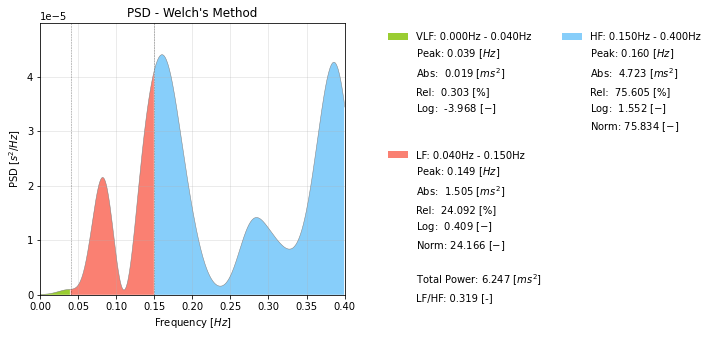

(0.0390625, 0.1494140625, 0.16015625)


In [32]:
import pyhrv.frequency_domain as fd
nni = tools.nn_intervals(rr_intervals_list)
result = fd.welch_psd(nni=nni)
# Access peak frequencies using the key 'fft_peak'
print(result['fft_peak'])

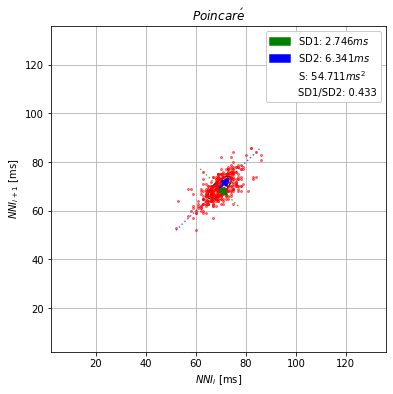

2.7462132835222093


In [33]:
import pyhrv.nonlinear as nl
result = nl.poincare(nni)
print(result['sd1'])

In [34]:
result = nl.sample_entropy(nni)
print(result['sampen'])

1.9786368425578704


- Makowski, D., Pham, T., Lau, Z. J., Brammer, J. C., Lesspinasse, F., Pham, H., Schölzel, C., & S H Chen, A. (2020). NeuroKit2: A Python Toolbox for Neurophysiological Signal Processing. Retrieved May 07, 2020, from https://github.com/neuropsychology/NeuroKit
- https://www.kaggle.com/stetelepta/exploring-heart-rate-variability-using-python